In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

## Purpose
The purpose of this notebook is to work out the code for how to combine and average tetrode pairs over brain areas over multiple sessions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

In [3]:
from src.analysis import (decode_ripple_clusterless,
                          detect_epoch_ripples,
                          ripple_triggered_connectivity,
                          connectivity_by_ripple_type)
from src.data_processing import (get_LFP_dataframe, make_tetrode_dataframe,
                                 save_ripple_info,
                                 save_tetrode_info)
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
epoch_keys = [('HPa', 6, 2), ('HPa', 6, 4)]

In [5]:
def estimate_ripple_coherence(epoch_key):
    ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

    tetrode_info = make_tetrode_dataframe(ANIMALS)[epoch_key]
    tetrode_info = tetrode_info[
        ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]

    lfps = {tetrode_key: get_LFP_dataframe(tetrode_key, ANIMALS)
            for tetrode_key in tetrode_info.index}

    # Compare all ripples
    for parameters_name, parameters in MULTITAPER_PARAMETERS.items():
        ripple_triggered_connectivity(
            lfps, epoch_key, tetrode_info, ripple_times, parameters,
            FREQUENCY_BANDS,
            multitaper_parameter_name=parameters_name,
            group_name='all_ripples')
        
#     save_tetrode_info(epoch_key, tetrode_info)

### Make sure we can get the ripple-triggered connectivity for two epochs

In [16]:
for epoch_key in epoch_keys:
    estimate_ripple_coherence(epoch_key)

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.02, time_window_step=0.02, detrend_type='constant', start_time=-0.42)
Maximum iterations reached. 0 of 41 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.1, time_window_step=0.1, detrend_type='constant', start_time=-0.5)
Maximum iterations reached. 0 of 10 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.25, time_window_step=0.25, detrend_type='constant', start_time=-0.75)
Maximum iterations reached. 0 of 5 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.5, time_window_step=0.5, detrend_type='constant', start_time=-1.0)
Maximum iterations reached. 0 of 3 converged
Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1, time_window_duration=0.05, time_window_step=0.05, detrend_type='constant', start_time=-0.45)
Maximum iterations reached. 0

### Now figure out how to combine the epochs

In [7]:
from glob import glob

def read_netcdfs(files, dim, transform_func=None, group=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path, group=group) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    return xr.concat(datasets, dim)

In [34]:
combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/coherence',
                        transform_func=None)

### Use tetrode info to index into the epoch arrays to select out the relevant brain areas

In [35]:
tetrode_info = pd.concat(make_tetrode_dataframe(ANIMALS).values())
tetrode_info = tetrode_info[
        ~tetrode_info.descrip.str.endswith('Ref').fillna(False)]
tetrode_info = tetrode_info.loc[
    (tetrode_info.animal=='HPa') &
    (tetrode_info.day == 6) &
    (tetrode_info.epoch.isin((2, 4)))]

Show that the indexing works by getting all the CA1-PFC tetrode pairs and averaging the coherence over the two epochs to get the average CA1-PFC coherence. In this case we show two plots of two different frequency bands to show the flexibility of using the `xarray` package.

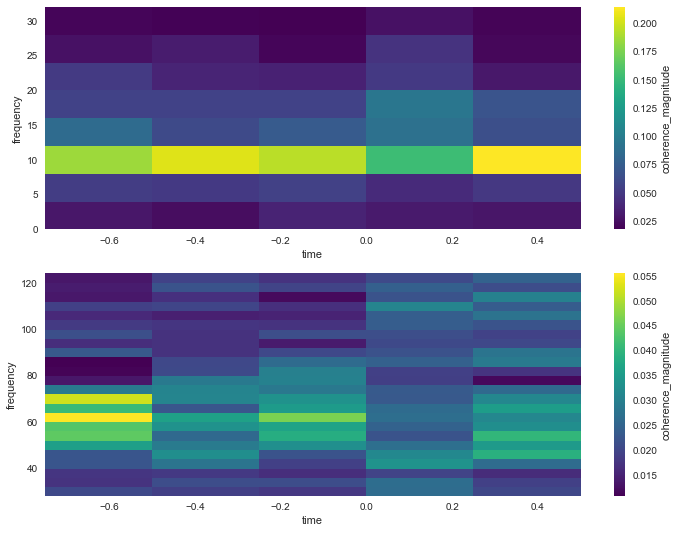

In [36]:
coh = (
    combined
    .sel(
        tetrode1=tetrode_info.query('area == "CA1"').tetrode_id.values,
        tetrode2=tetrode_info.query('area == "PFC"').tetrode_id.values)
    .coherence_magnitude
    .mean(dim=['tetrode1', 'tetrode2', 'session']))

fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);

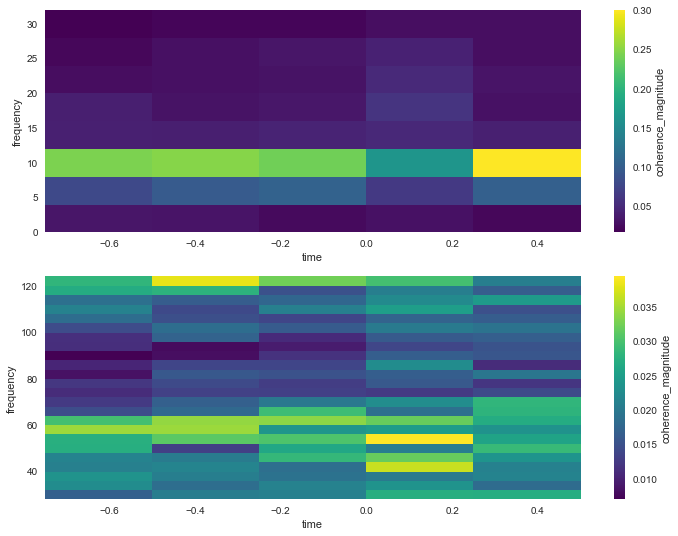

In [11]:
coh = (
    combined
    .sel(
        tetrode1=tetrode_info.query('area == "iCA1"').tetrode_id.values,
        tetrode2=tetrode_info.query('area == "PFC"').tetrode_id.values)
    .coherence_magnitude
    .mean(dim=['tetrode1', 'tetrode2', 'session']))

fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);

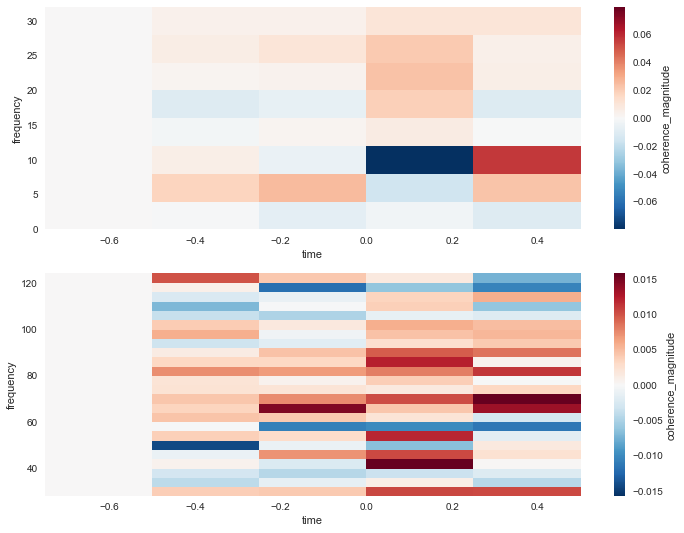

In [14]:
coh_diff = ((combined - combined.isel(time=0))
            .sel(
        tetrode1=tetrode_info.query('area == "iCA1"').tetrode_id.values,
        tetrode2=tetrode_info.query('area == "PFC"').tetrode_id.values)
            .coherence_magnitude
            .mean(dim=['tetrode1', 'tetrode2', 'session']))

fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh_diff.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh_diff.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);

### Alternatively we can use the transform function in the `read_netcdf` function to select brain areas

In [22]:
from functools import partial

def select_brain_areas(dataset, area1='', area2=''):
    if 'tetrode1' in dataset.coords:
        return dataset.sel(
            tetrode1=dataset.tetrode1[dataset.brain_area1==area1],
            tetrode2=dataset.tetrode2[dataset.brain_area2==area2]
        )
    else:
        # The dataset is power
        return dataset.sel(
            tetrode=dataset.tetrode[dataset.brain_area==area1],
        )

CA1_PFC = partial(select_brain_areas, area1='CA1', area2='PFC')

combined = read_netcdfs('../Processed-Data/*.nc', dim='session',
                        group='4Hz_Resolution/all_ripples/coherence',
                        transform_func=CA1_PFC)

combined

<xarray.Dataset>
Dimensions:              (frequency: 188, session: 2, tetrode1: 12, tetrode2: 12, time: 5)
Coordinates:
  * tetrode2             (tetrode2) object 'HPa6215' 'HPa6216' 'HPa6217' ...
  * tetrode1             (tetrode1) object 'HPa621' 'HPa622' 'HPa624' ...
  * time                 (time) float64 -0.625 -0.375 -0.125 0.125 0.375
  * frequency            (frequency) float64 2.0 6.0 10.0 14.0 18.0 22.0 ...
    brain_area1          (session, tetrode1) object 'CA1' 'CA1' 'CA1' 'CA1' ...
    brain_area2          (session, tetrode2) object 'PFC' 'PFC' 'PFC' 'PFC' ...
Dimensions without coordinates: session
Data variables:
    coherence_magnitude  (session, time, frequency, tetrode1, tetrode2) float64 3.058e-05 ...

In [28]:
print(combined.brain_area1)
print(combined.brain_area2)

<xarray.DataArray 'brain_area1' (session: 2, tetrode1: 12)>
array([['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1']], dtype=object)
Coordinates:
  * tetrode1     (tetrode1) object 'HPa621' 'HPa622' 'HPa624' 'HPa625' ...
    brain_area1  (session, tetrode1) object 'CA1' 'CA1' 'CA1' 'CA1' 'CA1' ...
Dimensions without coordinates: session
<xarray.DataArray 'brain_area2' (session: 2, tetrode2: 12)>
array([['PFC', 'PFC', 'PFC', 'PFC', 'PFC', 'PFC', nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, 'PFC', 'PFC', 'PFC', 'PFC', 'PFC', 'PFC']], dtype=object)
Coordinates:
  * tetrode2     (tetrode2) object 'HPa6215' 'HPa6216' 'HPa6217' 'HPa6218' ...
    brain_area2  (session, tetrode2) object 'PFC' 'PFC' 'PFC' 'PFC' 'PFC' ...
Dimensions without coordinates: session


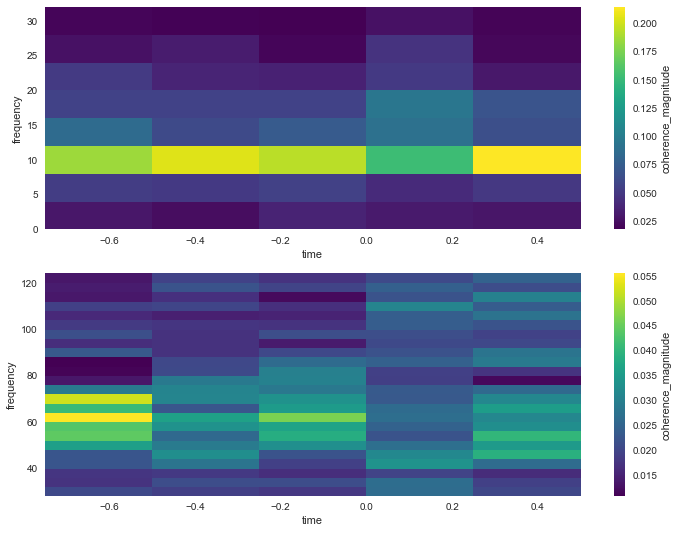

In [33]:
coh = combined.mean(['tetrode1', 'tetrode2', 'session']).coherence_magnitude
fig, axes = plt.subplots(2, 1, figsize=(12, 9))
coh.sel(frequency=slice(0, 30)).plot(x='time', y='frequency', ax=axes[0]);
coh.sel(frequency=slice(30, 125)).plot(x='time', y='frequency', ax=axes[1]);